In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector

## Data Analysis of ACS 20011-2021 survey using SQL and Python
## Data obtained from: https://usa.ipums.org/usa/index.shtml

In [176]:
# settings
plt.style.use('tableau-colorblind10')

In [227]:
try:
    with open("password.txt", 'r') as f:
        pwd = f.read()
except FileNotFoundError:
    with open("password.txt", 'w') as f:
        pass

In [14]:
# Using SQL just as an excercise 
db = mysql.connector.connect(host = 'localhost', 
                             user='root', 
                             passwd = pwd,
                             db='acs',
                             allow_local_infile = True
                            )

In [15]:
mycursor = db.cursor()

In [17]:
# drop Acs table before creating the table
mycursor.execute("DROP TABLE Acs")

In [18]:
# Create table for ACS 2011 and 2021 data
mycursor.execute("""
CREATE TABLE Acs (
    ID INT PRIMARY KEY AUTO_INCREMENT, 
    YEAR INT,
    SAMPLE VARCHAR(100),
    SERIAL VARCHAR(100),
    HHWT INT,
    STRATA INT,
    GQ INT,
    PERNUM INT,
    PERWT INT,
    NCHILD INT,
    NCHLT5 INT,
    SEX SMALLINT UNSIGNED,
    AGE SMALLINT UNSIGNED,
    MARST SMALLINT UNSIGNED,
    RACE SMALLINT UNSIGNED,
    RACED INT,
    CITIZEN SMALLINT UNSIGNED,
    YRIMMIG INT,
    SPEAKENG SMALLINT UNSIGNED,
    SCHOOL SMALLINT UNSIGNED,
    EDUC SMALLINT UNSIGNED,
    EDUCD INT,
    EMPSTAT SMALLINT UNSIGNED,
    EMPSTATD INT,
    WKSWORK2 SMALLINT UNSIGNED,
    UHRSWORK INT,
    WRKLSTWK INT,
    INCTOT INT,
    INCWAGE INT
    )
""")

In [19]:
# Insert the data from the acs csv file
mycursor.execute("""
LOAD DATA LOCAL INFILE 'C:/Users/armym/Documents/sqlproject/usa_00007.csv' INTO TABLE Acs
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\n'
IGNORE 1 ROWS
 (YEAR, 
 SAMPLE, 
 SERIAL, 
 @dummy, 
 HHWT,
 @dummy, 
 STRATA, 
 GQ, 
 PERNUM,
 PERWT,
 NCHILD, 
 NCHLT5, 
 SEX, 
 AGE, 
 MARST,
 RACE, 
 RACED, 
 CITIZEN, 
 YRIMMIG, 
 SPEAKENG,
 SCHOOL, 
 EDUC, 
 EDUCD,
 EMPSTAT, 
 EMPSTATD, 
 WKSWORK2, 
 UHRSWORK, 
 WRKLSTWK,
 INCTOT, 
 INCWAGE
 );
""")

In [29]:
sql_clean = """
SELECT ID, YEAR, NCHILD, NCHLT5, MARST,
    CASE SEX
        WHEN 1 then 0
        ELSE 1
    END as SEX_NEW,
    AGE,
    CASE 
        WHEN RACE=3 THEN 1
        WHEN RACE IN (4, 5) THEN 2
        WHEN RACE = 2 THEN 3
        WHEN RACE = 6 THEN 4
        WHEN RACE = 1 THEN 5
        ELSE 6
    END AS RACE_NEW,
    CASE 
        WHEN CITIZEN = 0 THEN 1
        WHEN CITIZEN NOT IN (0, 9) THEN 0
        ELSE NULL
    END AS CITIZEN_NEW,
    IF(YRIMMIG > 0, 1, 0) AS IMMIGRANT,
    CASE
        WHEN YRIMMIG = 0 THEN 1
        ELSE 0
    END AS USCITIZEN,
    CASE
        WHEN SPEAKENG IN (0, 1) THEN 0
        WHEN SPEAKENG >= 7 THEN NULL
        ELSE 1
    END AS SPEAKENG_NEW,
    SCHOOL,
    FORMAT(CASE EDUC
        WHEN 1 THEN 4
        WHEN 2 THEN 8
        WHEN 3 THEN 9
        WHEN 4 THEN 10
        WHEN 5 THEN 11
        WHEN 6 THEN 12
        WHEN 7 THEN 13
        WHEN 8 THEN 14
        WHEN 9 THEN 15
        WHEN 10 THEN 16
        WHEN 11 THEN 17
    END, 0) AS GRADE,
    
    CASE 
        WHEN EMPSTAT IN (0,2,3) THEN 0
        ELSE 1
    END AS EMPSTAT_NEW,
    
    WKSWORK2,
    
    IF(UHRSWORK=99, NULL, UHRSWORK) AS UHRSWORK_NEW,
    CASE 
        WHEN WRKLSTWK=2 THEN 1
        WHEN WRKLSTWK=1 THEN 2
        WHEN WRKLSTWK IN (0,3) THEN NULL
    END AS WRKLSTWK_NEW,
    
    IF(INCWAGE>=999999 , NULL, INCWAGE) AS INCWAGE_NEW

    FROM acs
    WHERE AGE BETWEEN 18 AND 55
"""
#     IF(EMPSTAT=1 AND UHRSWORK > 0 AND WRKLSTWK=1 AND INCWAGE>0, INCWAGE/WKSWORK2, NULL) AS WEEKLYEARNINGS

In [177]:
# create weekly earnings variable
sql_clean2 = """
WITH acs_cleaned as ({})
SELECT *, IF(EMPSTAT_NEW=1 AND UHRSWORK_NEW > 0 AND WRKLSTWK_NEW=1 AND INCWAGE_NEW>0, INCWAGE_NEW/WKSWORK2, NULL) AS WEEKLYEARNINGS
FROM acs_cleaned
""".format(sql_clean)

In [178]:
# convert sql_clean query into a pandas data frame
df = pd.read_sql(sql_clean2, db)
print(df.head())
print("Shape: {}".format(df.shape))

C:\Users\armym\AppData\Local\Temp\ipykernel_49268\1745424006.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_clean2, db)


   ID  YEAR  NCHILD  NCHLT5  MARST  SEX_NEW  AGE  RACE_NEW  CITIZEN_NEW  \
0   1  2011       0       0      6        1   19         3            1   
1   9  2011       0       0      5        1   53         5            1   
2  10  2011       0       0      6        1   24         5            1   
3  11  2011       0       0      6        0   19         5            1   
4  13  2011       3       0      4        0   49         5            1   

   IMMIGRANT  USCITIZEN  SPEAKENG_NEW  SCHOOL GRADE  EMPSTAT_NEW  WKSWORK2  \
0          0          1             1       2    13            0         0   
1          0          1             1       1    13            0         0   
2          0          1             1       1    14            1         6   
3          0          1             1       2    13            0         0   
4          0          1             1       1    12            1         6   

   UHRSWORK_NEW  WRKLSTWK_NEW  INCWAGE_NEW  WEEKLYEARNINGS  
0           0.0    

In [ ]:
# alternitavley we create weekly earnings variable via pandas:
def create_weakly_earnings_var(df):
    def get_weakly_earnings(x):
        if x['EMPSTAT_NEW'] == 1 and x['UHRSWORK_NEW'] > 0 and x['WRKLSTWK_NEW'] == 1 and x['INCWAGE_NEW'] > 0:
            return x['INCWAGE_NEW'] / x['WKSWORK2']
    df['WEEKLYEARNINGS'] = df.apply(get_weakly_earnings, axis = 1)
    return df
# df = create_weakly_earnings_var(df)

In [23]:
mycursor.execute("DROP VIEW acs_cleaned")

In [24]:
# create view so we don't have to run sql_clean query again
columns = ', '.join(list(df.columns))

mycursor.execute(f"""
CREATE VIEW acs_cleaned
    ({columns})
AS
{sql_clean2}
""")

# look at the column names
print(columns)

ID, YEAR, NCHILD, NCHLT5, MARST, SEX_NEW, AGE, RACE_NEW, CITIZEN_NEW, IMMIGRANT, USCITIZEN, SPEAKENG_NEW, SCHOOL, GRADE, EMPSTAT_NEW, WKSWORK2, UHRSWORK_NEW, WRKLSTWK_NEW, INCWAGE_NEW, WEEKLYEARNINGS


In [ ]:
print(df.info())
print(df.describe())

In [179]:
df.head()

,ID,YEAR,NCHILD,NCHLT5,MARST,SEX_NEW,AGE,RACE_NEW,CITIZEN_NEW,IMMIGRANT,USCITIZEN,SPEAKENG_NEW,SCHOOL,GRADE,EMPSTAT_NEW,WKSWORK2,UHRSWORK_NEW,WRKLSTWK_NEW,INCWAGE_NEW,WEEKLYEARNINGS
0,1,2011,0,0,6,1,19,3,1,0,1,1,2,13,0,0,0.0,2.0,0,NaN
1,9,2011,0,0,5,1,53,5,1,0,1,1,1,13,0,0,0.0,2.0,0,NaN
2,10,2011,0,0,6,1,24,5,1,0,1,1,1,14,1,6,40.0,1.0,35000,5833.3333
3,11,2011,0,0,6,0,19,5,1,0,1,1,2,13,0,0,0.0,2.0,0,NaN
4,13,2011,3,0,4,0,49,5,1,0,1,1,1,12,1,6,40.0,1.0,38000,6333.3333


In [38]:
categorical = ['IMMIGRANT', "SEX_NEW", "RACE_NEW", "CITIZEN_NEW", "EMPSTAT_NEW", "SCHOOL", "MARST"]
ordinal = ["NCHILD", "AGE", "GRADE"]
# check NAN values
print(df.isna().sum())
print(df.isna().sum()/df.shape[0])

ID                      0
YEAR                    0
NCHILD                  0
NCHLT5                  0
MARST                   0
SEX_NEW                 0
AGE                     0
RACE_NEW                0
CITIZEN_NEW             0
IMMIGRANT               0
USCITIZEN               0
SPEAKENG_NEW            0
SCHOOL                  0
GRADE               78512
EMPSTAT_NEW             0
WKSWORK2                0
UHRSWORK_NEW         6478
WRKLSTWK_NEW       612260
INCWAGE_NEW             0
WEEKLYEARNINGS    2303580
dtype: int64
ID                0.000000
YEAR              0.000000
NCHILD            0.000000
NCHLT5            0.000000
MARST             0.000000
SEX_NEW           0.000000
AGE               0.000000
RACE_NEW          0.000000
CITIZEN_NEW       0.000000
IMMIGRANT         0.000000
USCITIZEN         0.000000
SPEAKENG_NEW      0.000000
SCHOOL            0.000000
GRADE             0.013046
EMPSTAT_NEW       0.000000
WKSWORK2          0.000000
UHRSWORK_NEW      0.001076
WRKLSTWK

In [187]:
def modify_axis(ax):
    ax.grid(axis='y',zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [206]:
import matplotlib.ticker as ticker

immigrant_counts = df['IMMIGRANT'].value_counts()
print(immigrant_counts)

imm_mapping = {0:"Non-immigrant", 1:'Immigrant'}
 
def plot_number_of_immigrants(ax):
    """Bar plot for number of immigrants and non-immigrants
    """
    immigrant_counts_df = immigrant_counts.reset_index()
    # add grid lines and remove axis lines
    modify_axis(ax)
    
    # bar chart
    ax.bar(immigrant_counts_df['IMMIGRANT'].map(imm_mapping), 
           immigrant_counts_df['count'], 
           color='skyblue',
           zorder=3
          )
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.set_title('Number of Immigrants and Non-immigrants')
    

IMMIGRANT
0    4994782
1    1023080
Name: count, dtype: int64


In [41]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [207]:
# calculate average weakly earnings for immigrants
avg_wklyearnings = df.groupby(['IMMIGRANT', 'YEAR'])[['WEEKLYEARNINGS']].mean()
avg_wklyearnings.rename({"WEEKLYEARNINGS": "Average weekly earnings"}, axis=1, inplace=True)
print(avg_wklyearnings)
# alternatively:

def get_avg_wklyearnings_sql():
    avg_wklyearnings_sql = """
    SELECT AVG(WEEKLYEARNINGS) as AVERAGE_WEEKLY_EARNINGS
    FROM acs_cleaned
    GROUP BY IMMIGRANT
    """
    return pd.read_sql(avg_wklyearnings_sql, db)

#avg_wklyearnings = get_avg_wklyearnings_sql()

def plot_avg_wklyearnings(ax):
    """Bar plot for weekly earnings per year for immigrants/non immigrants
    """
    modify_axis(ax)
    
    years = [2011, 2021]
    
    x = np.arange(2)  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0
    
    for imm in [0, 1]:
        offset = width * multiplier
        rects = ax.bar(x + offset, avg_wklyearnings.loc[imm]["Average weekly earnings"], 
                       width, 
                       label = "Immigrant" if imm == 1 else "Non-immigrant",
                       zorder = 3
                      )
        ax.bar_label(rects, padding=3)
        multiplier += 1
        
    ax.set_xticks(x + (width/2), years)
    ax.set_facecolor('white')
    ax.legend()
    ax.set_title("Average Weekly Earnings For Immigrants/Non Immigrants by Year")


                Average weekly earnings
IMMIGRANT YEAR                         
0         2011              7956.840726
          2021             11295.320103
1         2011              7770.098474
          2021             12298.304542


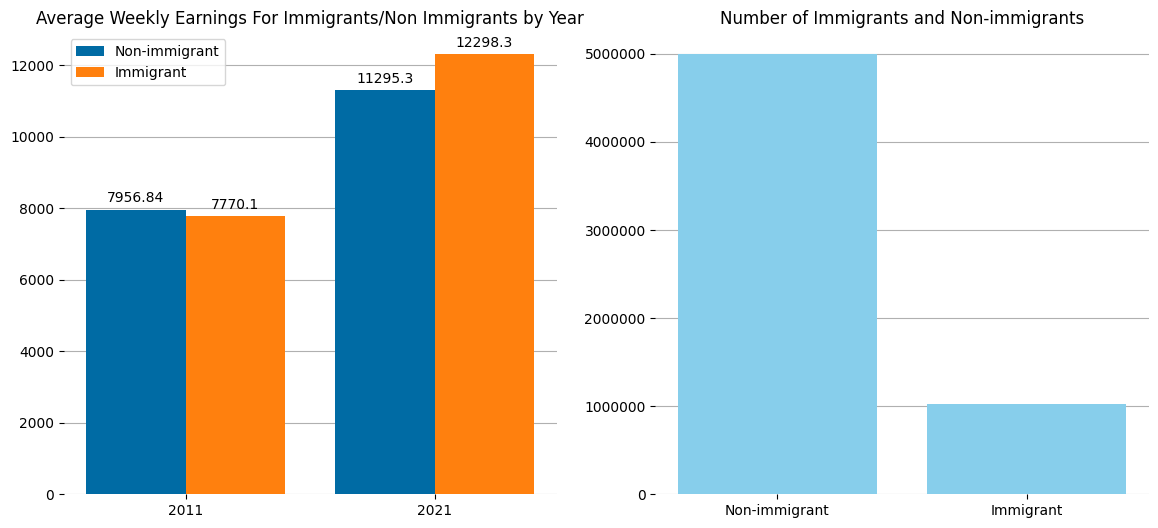

In [208]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
plot_avg_wklyearnings(ax[0])
plot_number_of_immigrants(ax[1])